# What kind of Beer do you want?

# Names

- George Liu, A15836054
- Xinyao Yi, A59019592
- Yingnan Yang, A16018172

# Abstract

For adults, beer is one of the most highly consumed beverages; wouldn't you want to find a beer that is best for you? In order to do this, we want to examine how people rate beers. This includes things such as alcohol percentage, smell, and taste. Our goal is to build a model that predicts the ratings of beer given these attributes/features, extend the model to also recommend beers based upon your own preferences to these features.

Once we filter our dataset with the necessary features, we will train a baseline linear regression model and then a more complex fully connected neural network to see how it performs, using metrics such as RMSE, MAE, and R2 correlation coefficient. These metrics will help us determine the best model, and in turn allow us to recommend the best beer for you.

# Background

Our research problem is pretty unique in that researches don’t look into a topic like this. Mostly, this is because this topic is not super important to globalization and technological improvements. There are some works that are similar in topic, but none are academic. 

One way people use this dataset is to research the types of preferences people have in beer, things like how much foam a person wants, how much alcohol percentage is in the drink, etc. This mostly is used for improving the sales of beer and crafting the best drink. <sup>[1](#preferences)</sup>

Others have used beer reviews as a way for classification, being easily able to classify a beer into some categories for ease and also increases sales. <sup>[2](#classification)</sup>

A similar drink to beer is wine, and they are experimenting with computer vision to find when the optimal time is to use the ingredients, aka harvesting the grapes. A similar application can be used on barley, the ingredient to make beer. <sup>[3](#beer)</sup>

# Problem Statement/Research Problem
We aim to suggest the best beer for you based upon common beer preferences; things such as alcohol level, appearence, bitterness, etc. In the process of doing this, we will also aim to predict ratings based upon these preferences; which can be replicated through our model architecture (there is no randomness). This problem is both quantifiable (as our predicted ratings we can get a definite number), and also measurable, through our error metrics that we present below.

# Dataset

https://www.kaggle.com/datasets/ruthgn/beer-profile-and-ratings-data-set

This dataset can be found above at the link provided. It has 3197 beer reviews, and 25 total features (3197x25). Each sample will consist of something similar to the name of the drink, a few columns representing the preferences of beers like alcohol level, and then the overall review rating. For our data, we need preprocess by filtering out useless columns and also selecting columns that can easily fit into our neural network architecture (for example getting columns that are integers/floats) so we don't have to one hot encode unnecessary features. We also should drop any sample that is empty in the columns that we find useful.

To create our training set and test set, we need to first extract the overall rating score from the dataset as our y values (labels). Then, we extract all the columns that we find important and use that as our X. Then we can use test_train split to get the necessary proportions for our model to be generalizable.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

2023-03-05 08:07:57.634306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 08:07:57.860749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-05 08:07:57.860800: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-05 08:08:00.101374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
df = pd.read_csv('beer_profile_and_ratings.csv')

In [3]:
df.shape

(3197, 25)

In [4]:
df = df.dropna()

In [5]:
df.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


In [6]:
df.dtypes

Name                  object
Style                 object
Brewery               object
Beer Name (Full)      object
Description           object
ABV                  float64
Min IBU                int64
Max IBU                int64
Astringency            int64
Body                   int64
Alcohol                int64
Bitter                 int64
Sweet                  int64
Sour                   int64
Salty                  int64
Fruits                 int64
Hoppy                  int64
Spices                 int64
Malty                  int64
review_aroma         float64
review_appearance    float64
review_palate        float64
review_taste         float64
review_overall       float64
number_of_reviews      int64
dtype: object

Getting only the desired features to train our neural network

In [7]:
beer_names = df.loc[:,'Name']
y = df.loc[:, 'review_overall']

In [8]:
X = df.drop(['Name','Style','Brewery','Beer Name (Full)', 'Description'], axis=1)

This is what our first 5 samples look like.

In [9]:
X.head()

,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,5.3,25,50,13,32,9,47,74,33,0,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,7.2,25,50,12,57,18,33,55,16,0,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,5.0,25,50,14,37,6,42,43,11,0,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,8.5,25,50,13,55,31,47,101,18,1,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,7.2,25,50,25,51,26,44,45,9,1,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


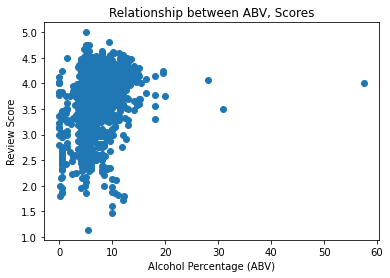

In [10]:
# Create a scatter plot of two variables
plt.scatter(df['ABV'], df['review_overall'])

# Add axis labels and a title
plt.xlabel('Alcohol Percentage (ABV)')
plt.ylabel('Review Score')
plt.title('Relationship between ABV, Scores')

# Show the plot
plt.show()

Here, we are looking at if there is a relationship between alcohol percentage and review score, but from the plot it seems there isn't a correlation. Let's see how good our model is given that it seems each of these variables don't correlate too much to the rating.

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# convert everything to float for ease of use
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Proposed Solution:
We will first create a baseline linear regression model to get a feel for how it performs. We don't expect this to be great, because it will train slow compared to a neural network and is prone to outliers. However, it will help determine the relationship between features and help select which features are the most important to help other models. 

From these results, we will create a fully connected neural network, which is useful because it can use backpropogation to fix previous misclassifications. This will make the model much more accurate. However, because of our limited data, we may expect overfitting on the model. To try to deal with this, we will also use adam as our optimizer; since an adaptive learning rate can help emphasize important features in the middle of training.

Finally, using the neural network, we will create a basic recommendation system that takes input from the user and inputs into our model to predict. We will need to add some logic to return the name of the beer that the model prediction corresponds to.

# Evaluation Metrics:

Our model isn't doing any classification, we already know all drinks that we predict are going to be beers. That means things like confusion matricies, F1 score, precision, etc. are not applicable. Instead, we would have to use things like Mean Absolute Error, Root Mean Squared Error, and R2 correlation coefficients to evaluate our models. 

MAE is less sensitive to outliers than other metrics and is interpretable while RMSE penalizes the large errors. We will take both of these factors into account when choosing the best model and analyzing our results. Further, we can also use R2 correlation coefficient to help assess how good our predicted model is on the data.

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

This is also another metric we use to create visualizations to see the error between the predicted and true ratings.

In [14]:
def get_rating_diff(y_pred_ratings, y_test):
    """
    This function returns the difference between each predicting rating and the actual rating
    """
    return [np.absolute(pred_rating - true_rating) for pred_rating, true_rating in zip(y_pred_ratings, y_test)]
 

# Preliminary Results:

Here, we will train our baseline model, using a simple linear regression and see the performance.

In [15]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
model = DecisionTreeRegressor(max_depth=3)

In [16]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3)

In [17]:
y_pred_ratings = model.predict(X_test)

In [18]:
y_pred_ratings[:5]

array([3.83113682, 3.34068218, 4.06092513, 4.06092513, 2.59880472])

In [19]:
y_test[:5]

array([3.82622 , 3.229075, 4.109873, 4.093052, 2.383268], dtype=float32)

In [20]:
rating_diffs=get_rating_diff(y_pred_ratings,y_test)

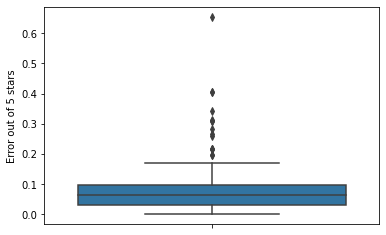

In [21]:
sns.boxplot(y=rating_diffs)
plt.ylabel('Error out of 5 stars')
plt.show()

From our boxplot, we can see that the average error of our predicted rating is around 0.2 stars, and there are quite a few outliers. Additionally the 75th percentile is at 0.6 stars, which is a pretty significant amount in a 5 star rating system.

In [22]:
mae = mean_absolute_error(y_test, y_pred_ratings)
mae

0.0693127267064461

In [23]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ratings))
rmse

0.08874716455994469

In [24]:
r2 = r2_score(y_test, y_pred_ratings)
r2

0.9568244595788258

We actually have really low errors, but we believe this is because the tree is overfitting on the training data and there isn't enough test data to accurately reflect this. An absolute error of 0.07 and rmse of 0.09 seems a little unreasonable when we can see that our box plot doesn't agree with this, and a super high value of r2 also leads us to believe the model is overfitting.

# Ethics/Privacy:

There is definitely bias when in this dataset. We say this because as humans, we don't really rate things 0 or 5 on a 0-5 scale. Unless something is super bad or super good, we probably would rate it in between something like 3.5 to 4.5. This can severely affect our model predictions, but doesn't really have a good solution for it. 

Additionally, the ratings of some samples may occur when a person is already drunk, causing them to rate much higher or lower than if they were sober. It may also depend on how much fun they had while drunk. This also is sampling error, which we can't do much about.

# Team Expectations

* Be available on the weekends to work together if neccessary, otherwise individually complete assigned work during weekday
* Inform all team members through group chat on updates/something is pushed to github
* Finish all required parts at least 2 days before deadline is due

# Project Timeline Proposal


| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/16  |  1 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 2/17  |  10 AM |  Do background research on topic and come up with basic model (George) | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/20  | 10 PM  | Edit, finalize, and submit proposal; Search for datasets (All)  | Assign group members to lead each specific part   |
| 3/1  | 6 PM  | Begin Neural Network architecture design/programming(George) | Discuss Analysis Plan   |
| 3/4 | 12 PM  | Write recommendation system(George) | Discuss/edit project code; Complete project |
| 3/12  | 12 PM  | Draft results/conclusion/discussion (Xinyao/Yingnan)| Discuss/edit full project |
| 3/19  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes

<a name="preferences">1</a>: AI of Things, one Telefonica Tech´s business unit. “The Use of AI and Machine Learning in the Beer Industry.” Think Big/Business, 18 June 2021, https://business.blogthinkbig.com/the-use-of-ai-and-machine-learning-in-the-beer-industry/. <br>

<a name="classification">2</a>: da Costa, Nattane Luíza, et al. “A Review on the Application of Chemometrics and Machine Learning Algorithms to Evaluate Beer Authentication - Food Analytical Methods.” SpringerLink, Springer US, 26 Sept. 2020, https://link.springer.com/article/10.1007/s12161-020-01864-7. 


<a name="beer">3</a>: Editor, MathWorks. “Making Better Beer and Wine with Data and Machine Learning.” Medium, MathWorks, 23 Sept. 2020, https://medium.com/mathworks/making-better-beer-and-wine-with-data-and-machine-learning-dd04459f53b7. 

## Fully Connected neural network

In [25]:
from keras.models import Sequential
from keras.layers import Dense

In [26]:
# model selection
model = Sequential()
model.add(Dense(64, input_shape=(20,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

2023-03-05 08:08:03.878975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-05 08:08:03.879033: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-05 08:08:03.879077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dsmlp-jupyter-g9liu): /proc/driver/nvidia/version does not exist
2023-03-05 08:08:03.879387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model Selection

We purposely decided to use relu and linear activation functions because we are dealing with a regression task. Relu allows us to train very efficient and linear activation function doesn't provide any bound restrictions on our predictions, which is what we want.

In [27]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
64/64 [==============================] - 1s 7ms/step - loss: 219.2885 - val_loss: 6.3826
Epoch 2/100
64/64 [==============================] - 0s 4ms/step - loss: 5.2280 - val_loss: 4.0512
Epoch 3/100
64/64 [==============================] - 0s 3ms/step - loss: 3.5192 - val_loss: 3.0792
Epoch 4/100
64/64 [==============================] - 0s 4ms/step - loss: 2.2984 - val_loss: 2.1042
Epoch 5/100
64/64 [==============================] - 0s 4ms/step - loss: 1.5023 - val_loss: 1.3645
Epoch 6/100
64/64 [==============================] - 0s 4ms/step - loss: 1.0379 - val_loss: 1.0482
Epoch 7/100
64/64 [==============================] - 0s 4ms/step - loss: 0.8102 - val_loss: 0.8361
Epoch 8/100
64/64 [==============================] - 0s 4ms/step - loss: 0.6527 - val_loss: 0.6975
Epoch 9/100
64/64 [==============================] - 0s 5ms/step - loss: 0.5031 - val_loss: 0.6974
Epoch 10/100
64/64 [==============================] - 0s 5ms/step - loss: 0.4328 - val_loss: 0.5063
Epoch 1

Epoch 83/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0332 - val_loss: 0.0616
Epoch 84/100
64/64 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.1055
Epoch 85/100
64/64 [==============================] - 0s 4ms/step - loss: 0.1378 - val_loss: 0.1032
Epoch 86/100
64/64 [==============================] - 0s 3ms/step - loss: 0.1442 - val_loss: 0.0535
Epoch 87/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0535
Epoch 88/100
64/64 [==============================] - 0s 4ms/step - loss: 0.0668 - val_loss: 0.1136
Epoch 89/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0789 - val_loss: 0.0561
Epoch 90/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 0.0562
Epoch 91/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0754 - val_loss: 0.0491
Epoch 92/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0679


In [29]:
model.save("beer_nn")

INFO:tensorflow:Assets written to: beer_nn/assets


INFO:tensorflow:Assets written to: beer_nn/assets


In [30]:
# Evaluate the model on the test set
y_pred_ratings = model.predict(X_test)
y_pred_ratings = np.clip(y_pred_ratings, 0, 5)

20/20 [==============================] - 0s 1ms/step


In [31]:
y_pred_ratings[:5]

array([[3.6552749],
       [3.195127 ],
       [4.3222194],
       [4.1671596],
       [2.3668227]], dtype=float32)

In [32]:
y_test[:5]

array([3.82622 , 3.229075, 4.109873, 4.093052, 2.383268], dtype=float32)

In [33]:
rating_diffs=get_rating_diff(y_pred_ratings,y_test)
rating_diffs=[rating[0] for rating in rating_diffs]

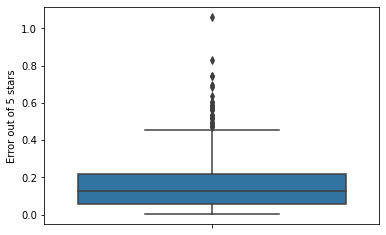

In [34]:
sns.boxplot(y=rating_diffs)
plt.ylabel('Error out of 5 stars')
plt.show()

As we can see, the average error as well as the 75th percentile displayed in the boxplot for the neural network is lower than our original baseline, so this model performs a little bit better.

Our problem is not a classification problem, so we can't use things like confusion matricies and therefore f1 score, precision, recall are not appropriate.

In [35]:
mae = mean_absolute_error(y_test, y_pred_ratings)
mae

0.1571799

In [36]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ratings))
rmse

0.20865446

In [37]:
r2 = r2_score(y_test, y_pred_ratings)
r2

0.7613375070663615

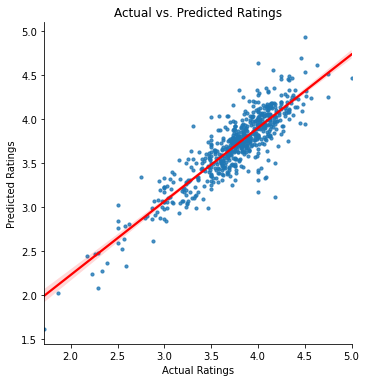

In [38]:
df2 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_ratings.flatten()})

# create a scatter plot with a regression line
sns.lmplot(x='Actual', y='Predicted', data=df2, line_kws={'color': 'red'},scatter_kws={'s': 10})

# set the x and y-axis labels
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')

# set the plot title
plt.title('Actual vs. Predicted Ratings')

# display the plot
plt.show()

# Building Recommendation System From Model 

In [39]:
model = load_model("beer_nn")

In [40]:
df.columns

Index(['Name', 'Style', 'Brewery', 'Beer Name (Full)', 'Description', 'ABV',
       'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 'Bitter',
       'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty',
       'review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'review_overall', 'number_of_reviews'],
      dtype='object')

First, we just want to test a basic recommendation system. To do this, we will only heavily weigh the what we believe is the most important feature, the alcohol percentage. For the rest of the features, we will just use the mean values of the dataset to input to our model.

In [41]:
feature_means = df.mean()

/tmp/ipykernel_104273/1450019571.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_means = df.mean()


Getting the ABV level you want

In [42]:
abv_input = float(input('What alcohol percentage (0-100) do you want? '))

What alcohol percentage (0-100) do you want? 6.9


Now, using the model we created earlier, we predict the rating the beer would get with your desired ABV level. Then, we get the top 10 closest beers with that rating, and give you beer with the closest ABV level to what you desired out of those 10 choices.

In [43]:
feature_means['ABV'] = abv_input
user_input = feature_means.values.reshape(1, -1)
beer_ratings = model.predict(user_input)[0][0]

1/1 [==============================] - 0s 105ms/step


In [44]:
beer_ratings

3.7244773

In [45]:
df['rating_difference'] = abs(df['review_overall'] - beer_ratings)

In [46]:
df = df.sort_values('rating_difference')

In [47]:
top_ten=df[:10]

In [48]:
df_closest = top_ten.iloc[(top_ten['ABV']-abv_input).abs().argsort()[:1]]

/tmp/ipykernel_104273/1088758079.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_closest = top_ten.iloc[(top_ten['ABV']-abv_input).abs().argsort()[:1]]


In [51]:
df_closest

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,rating_difference
284,Emancipator Doppelbock,Bock - Doppelbock,Christian Moerlein Brewing Company,Christian Moerlein Brewing Company Christian M...,Notes:Christian Moerlein Doppelbock is brewed ...,7.0,17,27,17,60,...,35,11,128,3.475,3.775,3.725,3.475,3.725,20,0.000523


# Conclusion: TODO